# Compensatory frameshifting indels

Today we are going to reproduce the algorithm I created for my undergrad thesis (see [this paper](https://academic.oup.com/mbe/article/39/3/msac031/6524633)) for identification of compensatory frameshifting indels.

<center><div>
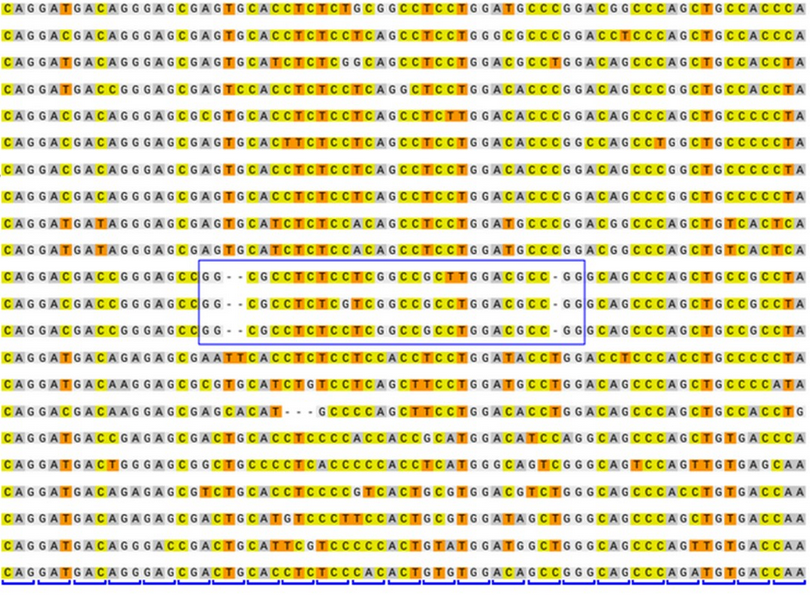
</div></center>


Strategy:
- Detect all indels
- Classify all which we can into insertions and deletions
- Figure out which ones are mutually compensatory

## Loading a multiple sequence alignment

Multiple Sequence Alignments (MSA) are often stored in FASTA format: <br><br>
\>Sequence Name #1 <br>
ATGC...GTTA <br>
\>Sequence Name #2 <br>
ATGT...ATAA <br>


Here is the file we are going to work with:

In [ ]:
with open ("files/sequences.fasta", "r") as fl:
    fasta = fl.read()
print(fasta)

There are many ways to load it into our program. You can load the alignment as a single string or use a native biopython data structure. But let's do it with dictionaries for simplicity

Now let's write a function that will create a list of dictionaries out of a FASTA file.

In [ ]:
def make_list_of_sequences(path_to_file):
    """
    Takes a FASTA file with aligned sequences and their names.
    Returns a list of dictionaries, each dictionary representing a sequence.
    """
    seqs = []
    
    current_name = None
    current_sequence = []
    with open(path_to_file, "r") as fl:
        for line in fl.readlines():
            line = line.strip()
            if line.startswith('>'): # Then it's a name of a new sequence
                if current_name is not None: # Save previous sequence if exists
                    seq = ''.join(current_sequence)
                    new_seq = dict(name=current_name, gene=seq, holes=[], indels=[])
                    seqs.append(new_seq)
                    
                current_name = line.lstrip('>') # Give a name to the new sequence
                current_sequence = [] # Clear out the sequence of the new sequence
            else:
                current_sequence.append(line) # If it's a line with sequence, add this line to the current sequence's gene sequence
        if current_name is not None: # Add the last sequence to the list
            seq = ''.join(current_sequence)
            seqs.append(dict(name=current_name, gene=seq, holes=[], indels=[]))
    return seqs

In [ ]:
sequences = make_list_of_sequences("files/sequences.fasta")
sequences = sorted(sequences, key=lambda seq: int(seq["name"].split("_")[-1]))
sequences[0]

In [ ]:
for sequence in sequences:
    print(f"{sequence['gene'][:65]}...{sequence['gene'][-60:]} {sequence['name']}")

We will represent indels with dictionaries as well.

In [ ]:
indel1 = dict(position=10, length=2, name="Del")
print(indel1)

Now let's create a function that will list all the indels in the alignment. We can identify a potential indel by a series of gaps in at least one of the sequences. I will call them holes.

In [ ]:
import re
def find_holes(seq):
    matches = re.finditer(r'-+', seq)
    return [dict(position=match.start()+1, length=len(match.group()), name=None) for match in matches]
find_holes(sequences[0]["gene"])

In [ ]:
def make_list_of_holes(seqs):
    """
    Takes a list of sequences.
    Detects holes in all the sequences, reflects it in their "holes" attributes.
    Returns the set of unique holes across all the sequences.
    """
    all_holes = []
    for seq in seqs:
        holes = find_holes(seq["gene"])
        seq["holes"] = holes
        print(seq["name"], holes)

        # If hole already exists in our list, skip it
        for new_hole in holes:
            exists = False
            for existing_hole in all_holes:
                if new_hole["position"] == existing_hole["position"] and new_hole["length"] == existing_hole["length"]:
                    exists = True
            if not exists:
                all_holes.append(new_hole)
    return all_holes

In [ ]:
all_holes = make_list_of_holes(sequences)

In [ ]:
# Notice that all_holes contains only unique holes
print(all_holes)

## Classifying detecting insertions and deletions using holes

We need a tree for this task
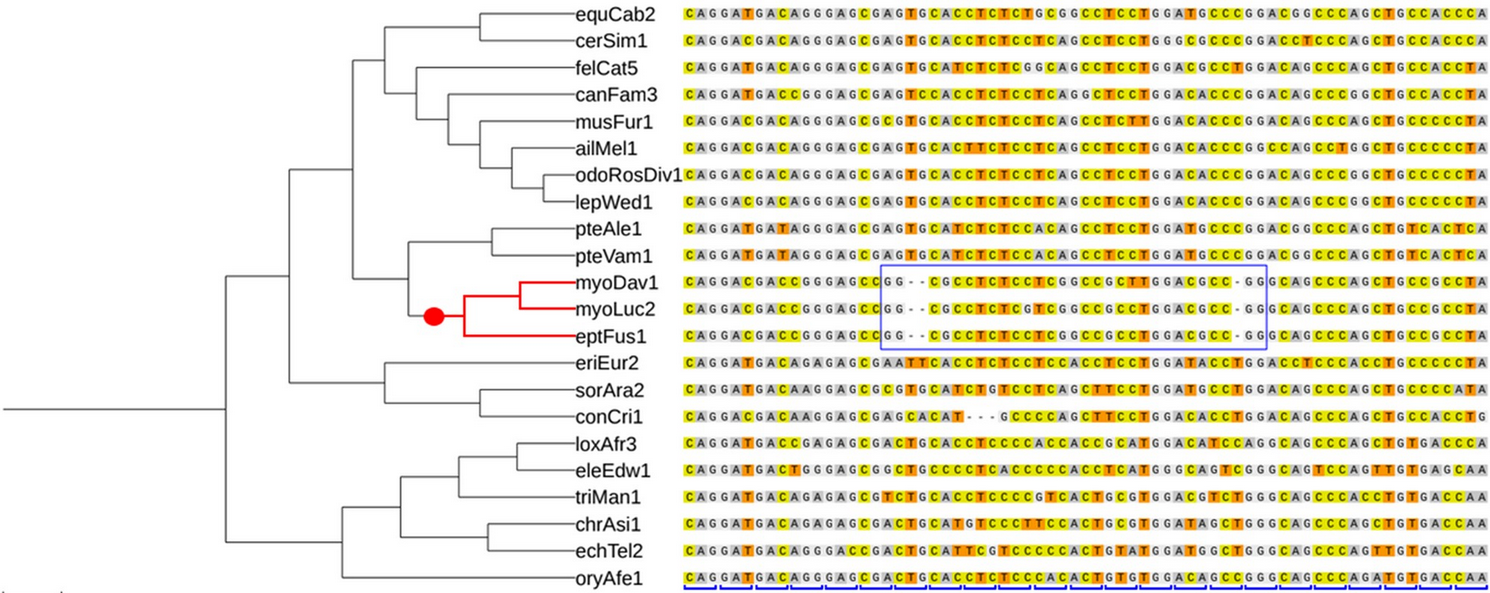

## Newick format

Phylogenetic trees are most commonly stored in newick format (.nwk). Here is a toy newick tree from wikipedia: <br>
## (A:0.1,B:0.2,(C:0.3,D:0.4)E:0.5)F; 
which looks like this: 

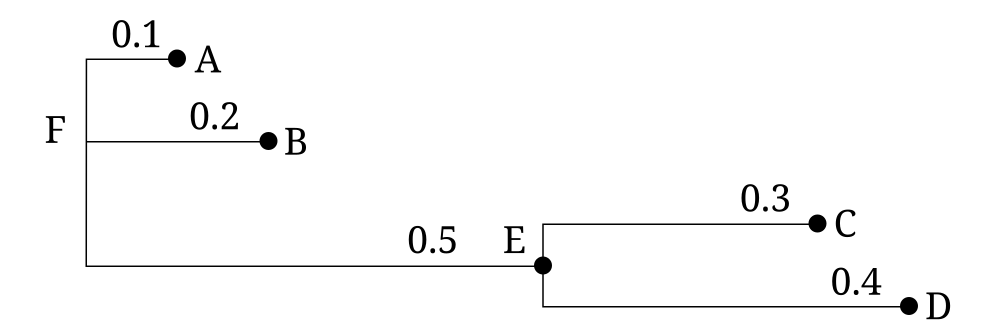

Now let's take a look at a sample newick file. <br>

In [ ]:
with open("files/tree.nwk", "r") as fl:
    newick_string = fl.read()
print(newick_string)

Phylo module of Biopython package allows loading newick files into Tree objects.
Tree objects represent phyogenetic trees in a way that makes working with them convenient <br>
(Even though, arguably, Phylo module is not the best at doing that, e.g. see ete3) <br>
One thing you might want to do with your tree is to visualize it. Here is how you can do it:

In [ ]:
from Bio import Phylo

TREE = Phylo.read("files/tree.nwk", format="newick")
TREE

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(20, 10))
Phylo.draw(TREE, axes=ax, do_show=False)
ax.set_xlim(0, 10)
plt.show()

In [ ]:
# List all the terminal nodes of a tree
TREE.get_terminals()

In [ ]:
random_terminal_node = TREE.get_terminals()[10]
random_terminal_node

In [ ]:
TREE.get_path(random_terminal_node)

In [ ]:
# This will just give us the random_terminal_node itself
TREE.get_path(random_terminal_node)[-1]

In [ ]:
# How to get its parent?
# Answer here:

In [ ]:
# Which node is the last common ancestor of a set of leaves?
terminals = TREE.get_terminals()
some_random_nodes = [terminals[i] for i in [13, 15, 17]]
print("Here are my nodes:")
print([node.name for node in some_random_nodes])
print("Here is their last common ancestor:")
print(TREE.common_ancestor(some_random_nodes))

In [ ]:
def is_monophyletic(list_of_leaves):
    """
    Returns True if the last common ancestor of list_of_leaves have no other descendants  
    """
    ### Implement this function yourself:

In [ ]:
TREE.common_ancestor(["leaf_1"])

In [ ]:
is_monophyletic([node.name for node in some_random_nodes])

In [ ]:
def classify_sequences_for_hole(hole, seqs):
    """Classify sequences as having or not having a specific hole"""
    sequences_with_hole = []
    sequences_without_hole = []
    
    for seq in seqs:
        found_hole = False
        for ith_hole in seq["holes"]:
            if ith_hole["position"] == hole["position"] and ith_hole["length"] == hole["length"]:
                found_hole = True
                break

        # Implement missing logic:
            
    return sequences_with_hole, sequences_without_hole

In [ ]:
first_hole = all_holes[0]
sequences_with, sequences_without = classify_sequences_for_hole(first_hole, sequences)
print("Have a hole:")
print([seq["name"] for seq in sequences_with])
print("Don't have a hole:")
print([seq["name"] for seq in sequences_without])

In [ ]:
# Now let's detect insertions and deletions!

for hole in all_holes:    
    sequences_with_hole, sequences_without_hole = classify_sequences_for_hole(hole)
    
    # Check monophyly and make an inference for whether it is an insertion or a deletion
    monophyletic_insertion = is_monophyletic([seq["name"] for seq in sequences_without_hole])
    monophyletic_deletion = is_monophyletic([seq["name"] for seq in sequences_with_hole])
    # Process based on monophyly results
    if monophyletic_deletion and not monophyletic_insertion:
        for seq in sequences_with_hole:
            seq["indels"].append(dict(name="Del", position=hole["position"], length=hole["length"]))
    elif monophyletic_insertion and not monophyletic_deletion:
        for seq in sequences_without_hole:
            seq["indels"].append(dict(name="In", position=hole["position"], length=hole["length"]))
    else:
        print("Strange indel: ", hole)

In [ ]:
# Let's take a look at this strange indel
for seq in sequences:
    print(seq["gene"][130:170], seq["name"])

In [ ]:
Phylo.draw_ascii(TREE)

In [ ]:
for seq in sequences:
    print(seq["name"], seq["indels"])

## Figure out which ones are mutually compensatory

In [ ]:
for seq in sequences:
    # Getting rid of indels with length divisible by 3 - we are not interested in those.
    interesting_indels = list(filter(lambda el: el["length"] % 3 != 0, seq["indels"]))
    for indel1 in interesting_indels:
        for indel2 in interesting_indels:
            if indel1["position"] < indel2["position"]:
                if (indel1["name"] == indel2["name"] and (indel1["length"] + indel2["length"]) % 3 == 0) \
                        or (indel1["name"] != indel2["name"] and (indel1["length"] - indel2["length"]) % 3 == 0):
                    new_frameshift = (seq["name"], 
                                      f"{indel1['name']}_{indel1['position']}_{indel1['length']}", 
                                      f"{indel2['name']}_{indel2['position']}_{indel2['length']}")
                    print(new_frameshift)    